In [2]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pickle
import numpy as np

Colormap:

In [3]:
def stability_cmap(LE):
    vmin = np.min(LE[:,:])
    vmax = np.max(LE[:,:])
    colors1 = plt.cm.PuRd(np.linspace(.25, 1., 1024))[::-1]          
    colors2 = plt.cm.Blues(np.linspace(.25, 1., int(1024*vmax/abs(vmin))))
    colors = np.vstack((colors1, colors2))
    mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)
    mymap.set_under('white', 1.0)
    return mymap 

Parameters from the simulation:

In [4]:
beta = 2.3
sigma_2_max = .6
sigma_3_max = .4
n_sig_2 = 100
n_sig_3 = 100
sig_2 = np.arange(n_sig_2) * sigma_2_max/n_sig_2
sig_3 = np.arange(n_sig_2) * sigma_3_max/n_sig_2

# Block diagonalization

Loading the block diagonalization result:

In [5]:
cl = pickle.load(open("cluster_sync.p", "rb")) # 

Plotting block structure:

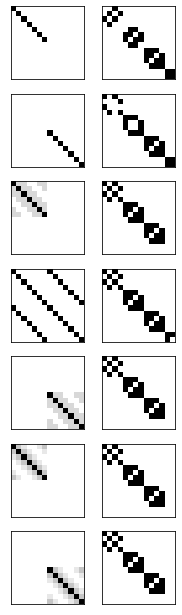

In [6]:
import matplotlib
import matplotlib.pyplot as plt
import pickle
fig, axs = plt.subplots(7,2, figsize=(3, 11.))
for i in range(7):
    axs[i,0].imshow(np.abs(cl.SBD_input[i]), 'Greys')
    axs[i,0].set_xticks([])
    axs[i,0].set_yticks([])
    axs[i,1].imshow(np.abs(cl.U_SBD.T @ cl.SBD_input[i] @ cl.U_SBD)>.01, 'Greys')
    axs[i,1].set_xticks([])
    axs[i,1].set_yticks([])

# Stability results

Loading stability results:

In [45]:
mle = pickle.load(open("mle_7_2.p", "rb")) 
quotient = pickle.load(open("quotient_7_2.p", "rb"))
n_sigma_2 = np.shape(norms)[0]
n_sigma_3 = np.shape(norms)[1]

In [46]:
np.shape(quotient) # (n_sigmas_2, n_sigmas_3, n_steps)

(100, 100, 200, 2)

In [47]:
np.shape(mle) # (n_sigmas_2, n_sigmas_3, n_steps, n_nodes_quotient_network)

(100, 100)

Additional clusters to check for:

In [48]:
extra_clusters = {} 
extra_clusters['0'] = [[0], [1]] 
extra_clusters['1'] = [[0, 1]] # full synchronization

Test which trajectories ended up synchronizing on a coarser cluster assignment:

In [49]:
n_test = 400
err = .001
cluster_indicators = {}
for cl_name in extra_clusters:
    errs = np.zeros((n_sigma_2, n_sigma_3))
    for cl in extra_clusters[cl_name]:
        cl_mean = np.expand_dims(np.mean(quotient[:, :, -n_test:, cl], axis=3), axis=3)
        cl_indexed = quotient[:, :, -n_test:, cl]
        cl_devs = np.sum(np.sum(np.abs(cl_indexed - cl_mean), axis=3), axis=2)
        errs+= cl_devs
    cluster_indicators[cl_name] =  errs < err

Showing which trajectories ended up fully synchronized:

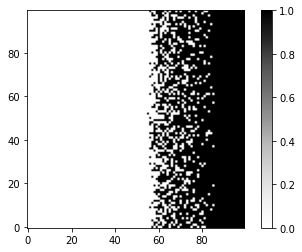

In [50]:
plt.imshow(cluster_indicators['1'].T, origin='lower', cmap='Greys') 
plt.colorbar()

Plot MLE: 

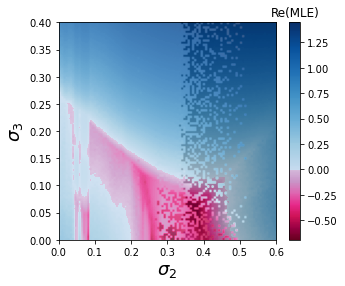

In [51]:
mymap = stability_cmap(mle)

extent=(0, sigma_2_max, 0, sigma_3_max)
plt.figure(0)
plt.imshow(mle.T, extent=extent, origin='lower', aspect=(3/2), cmap=mymap, alpha=1)
clb = plt.colorbar(fraction=0.045, pad=0.04)
plt.imshow(cluster_indicators['1'].T, extent=extent,origin='lower', aspect=3/2, cmap='Greys', alpha=.2)
plt.xlabel(r"$\sigma_2$", fontsize=18)
plt.ylabel(r"$\sigma_3$", fontsize=18)
clb.ax.set_title('Re(MLE)')
x = np.arange(100)*.6/100

# Plotting trajectories

Plot any trajectory:

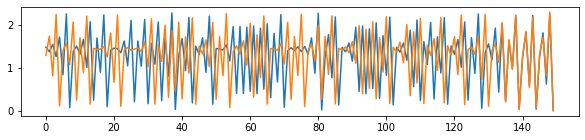

In [30]:
plt.figure(figsize=(10, 2))
plt.plot(quotient[20, 12, -150:, 0]) # 1.19 
plt.plot(quotient[20, 12, -150:, 1]) # .1

Some representative trajectories:

Text(0, 0.5, '$x_1[i]$')

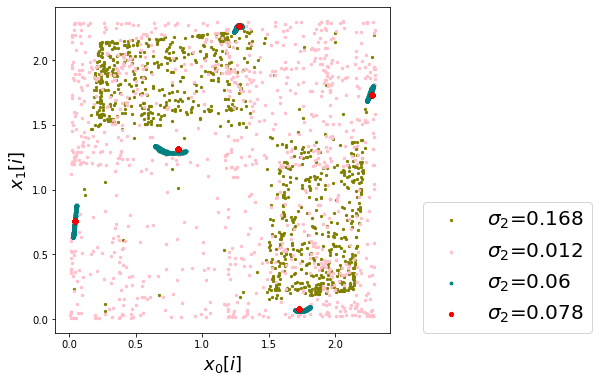

In [31]:
plt.figure(figsize=(6, 6))

t = quotient[28,0,:,:]
sig = 28*.6/100
plt.scatter(t[-1500:,0], t[-1500:,1], 5, color='olive', label=r"$\sigma_2$="+str(sig))

t = quotient[2,0,:,:]
sig = 2*.6/100
plt.scatter(t[-1500:,0], t[-1500:,1], 6, color='pink', label=r"$\sigma_2$="+str(sig))

t = quotient[10,0,:,:]
sig = 10*.6/100
plt.scatter(t[-1500:,0], t[-1500:,1], 8, color='teal', label=r"$\sigma_2$="+str(sig))

t = quotient[13,0,:,:]
sig = 13*.6/100
plt.scatter(t[-1500:,0], t[-1500:,1], 18, color='red', label=r"$\sigma_2$="+str(sig))

plt.legend(loc=(1.1,0), fontsize=20)

plt.xlabel(r"$x_0[i]$", fontsize=18)
plt.ylabel(r"$x_1[i]$", fontsize=18)

# Direct simulation

Explicitly simulating the dynamics:

In [34]:
b = np.zeros((2,5000))
b[:, 0] = np.random.rand(2)
for i in range(4999):
    s = .6/100 * 28
    b[0,i+1] = 2.3 * (np.sin(b[0,i] + np.pi/4))**2 + s * ((np.sin(b[1,i] + np.pi/4))**2 - (np.sin(b[0,i] + np.pi/4))**2)
    b[1,i+1] = 2.3 * (np.sin(b[1,i] + np.pi/4))**2 + s * ((np.sin(b[0,i] + np.pi/4))**2 - (np.sin(b[1,i] + np.pi/4))**2)

In [33]:
#plt.figure(figsize=(6, 6))
#plt.scatter(b[0,-1500:], b[1,-1500:], 8, color='b')

Reading out the dynamics with perturbations:

In [35]:
errors = np.zeros((10, 100))
for i in range(10):
    errors[i] = pickle.load(open("errs/err-" + str(i) + ".p", "rb")) 

Plotting together with MLE estimates:

Text(0, 0.5, '$\\sigma_3$')

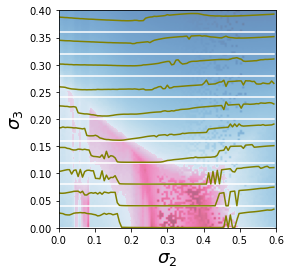

In [36]:
scale = .02
extent=(0, sigma_2_max, 0, sigma_3_max)
plt.figure()
plt.imshow(mle.T, extent=extent, origin='lower', aspect=(3/2), cmap=mymap, alpha=.6)
x = np.arange(100)*.6/100
for ind in range(10):
    y = [ind*.4/10]*100
    plt.plot(x,y, color='white')
    y = errors[ind] * scale + ind*.4/10
    plt.plot(x,y, color='olive')
plt.xlabel(r"$\sigma_2$", fontsize=18)
plt.ylabel(r"$\sigma_3$", fontsize=18)

Or separately:

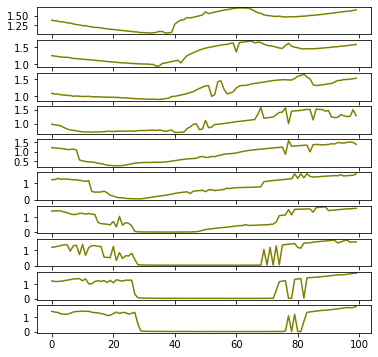

In [562]:
fig, axs = plt.subplots(10,1, figsize=(6, 6))
for i in range(10):
    axs[9-i].plot(errors[i], color='olive')

# Bifurcation diagram

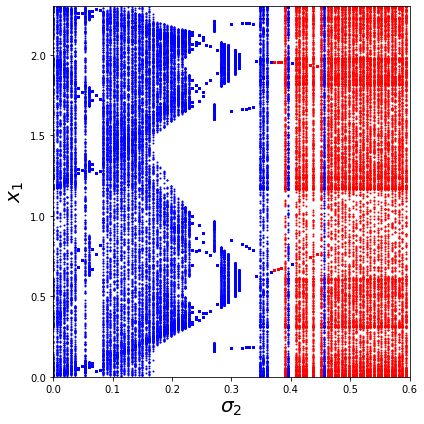

In [559]:
plt.figure(figsize=(6, 6))
plt.xlim(0, .6)
plt.ylim(0, 2.3)
for i in range(100):
    if cluster_indicators['1'][i,5]==False:
        x = [.6*i/100]*600
        y = quotient[i, 40, -600:, 1]
        plt.scatter(x, y, color='b', s=1)
    else:
        x = [.6*i/100]*600
        y = quotient[i, 20, -600:, 1]
        plt.scatter(x, y, color='r', s=1)
plt.xlabel(r"$\sigma_2$", fontsize=20)
plt.ylabel(r"$x_1$", fontsize=20)
plt.tight_layout()